# Feature Engineering for Bird Whisperer

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
from audio_processing import AudioProcessor
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
%pip install torch librosa numpy==1.24.4

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
Using cached soxr-0.5.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (252 kB)
  Attempting uninstall: numpy
    Found existing installation: nu

First we define some constants and load the metadata.

In [5]:
TRAIN_INPUT_FILE = "../data/cleaned/80_20_cleaned_train.parquet"
TEST_INPUT_FILE = "../data/cleaned/80_20_cleaned_test.parquet"
INPUT_AUDIO_DIR = "../data/raw/audio/xeno_canto"
OUTPUT_METADATA_DIR = '../data/processed/bird-whisperer'
OUTPUT_SPECTROGRAM_DIR = '../data/processed/bird-whisperer/spectograms'
SAMPLE_RATE = 16 * 1000 # 16kHz
SEGMENT_DURATION = 30 # whisper expects 30s segments
TARGET_RECORDINGS_PER_SPECIES = 100

train_df = pd.read_parquet(TRAIN_INPUT_FILE)
test_df = pd.read_parquet(TEST_INPUT_FILE)

ap = AudioProcessor(sample_rate=SAMPLE_RATE, segment_duration=SEGMENT_DURATION, target_db_level=-20, seed=42)

Then we calculate how many augmented samples we need for each species.

In [3]:
species_counts = train_df['en'].value_counts()

augmentation_factors = {}
for species, count in species_counts.items():
    if count > 100:
        max_augment_per_sample = 1
    elif count > 50:
        max_augment_per_sample = 2
    elif count > 25:
        max_augment_per_sample = 5
    else:
        max_augment_per_sample = 10

    needed_augmentations = max(0, TARGET_RECORDINGS_PER_SPECIES - count)
    augmentation_factors[species] = min(
        max(1, needed_augmentations // count), max_augment_per_sample
    )

Here the bulk of the work is done by loading all audio files and creating log mel spectrograms for each of them.

Finally we save the log mel spectrograms to disk.

In [4]:
# Parameters for log mel spectrogram according to the paper: "an 80-channel log-magnitude Mel-spectrogram is computed using 25-millisecond windows with a 10-millisecond stride, resulting in overlapping windows.""
log_mel_params = {
   "n_fft": int(0.025 * SAMPLE_RATE), # 25 milliseconds in samples
   "hop_length": int(0.010 * SAMPLE_RATE), # 10 milliseconds in samples
   "n_mels": 80 # Number of Mel bands
  }

print(f"Log mel spectrogram parameters: {log_mel_params}")

Log mel spectrogram parameters: {'n_fft': 400, 'hop_length': 160, 'n_mels': 80}


In [5]:
expected_audio_length = SAMPLE_RATE * SEGMENT_DURATION - 1
expected_spectogram_shape = ap.create_log_mel_spectrogram(np.zeros(expected_audio_length), n_fft=log_mel_params["n_fft"], hop_length=log_mel_params["hop_length"], n_mels=log_mel_params["n_mels"]).shape

def process_recordings(df, augment, output_spectogram_dir):
  outputs = []
  failed_files = {}
  os.makedirs(output_spectogram_dir, exist_ok=True)

  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
      # if index > 5:
      #     break

      audio_id = row['id']
      species_name = row['en']

      original_audio_file_name = row["file-name"]
      file_extension = original_audio_file_name.split(".")[-1]
      new_audio_file_name = f"{row['id']}.{file_extension}"
      full_audio_file_path = os.path.join(INPUT_AUDIO_DIR, new_audio_file_name)

      if not os.path.exists(full_audio_file_path):
        print(f"Audio file {new_audio_file_name} not found. Skipping.")
        continue

      try:
        # load and process the audio file
        audio_content = ap.process_audio_file_with_denoising(full_audio_file_path)
        assert len(audio_content) == expected_audio_length, f"Expected audio length {expected_audio_length} but got {len(audio_content)}"

        spectogram = ap.create_log_mel_spectrogram(audio_content, n_fft=log_mel_params["n_fft"], hop_length=log_mel_params["hop_length"], n_mels=log_mel_params["n_mels"])
        normalized_spectogram = ap.normalize_spectrogram(spectogram)
        
        assert normalized_spectogram.shape == expected_spectogram_shape, f"Expected spectogram shape {expected_spectogram_shape} but got {normalized_spectogram.shape}"

        # save the spectogram
        output_file_name = f"{audio_id}.pt"
        output_file_path = os.path.join(output_spectogram_dir, output_file_name)
        ap.save_log_mel_spectrogram(normalized_spectogram, output_file_path, type='torch')

        outputs.append({'id': audio_id, 'species': species_name, 'spectogram_file': output_file_name, 'augmented': False})

        if not augment:
          continue

        # augment the spectogram if needed
        for i in range(augmentation_factors.get(species_name, 0)):
          audio_content_aug = ap.add_augmentations(audio_content)
          assert len(audio_content) == expected_audio_length, f"Expected audio length {expected_audio_length} but got {len(audio_content)} after augmentation"

          spectogram = ap.create_log_mel_spectrogram(audio_content_aug, n_fft=log_mel_params["n_fft"], hop_length=log_mel_params["hop_length"], n_mels=log_mel_params["n_mels"])
          assert spectogram.shape == expected_spectogram_shape, f"Expected spectogram shape {expected_spectogram_shape} but got {spectogram.shape} after augmented audio"

          spectogram_aug = ap.apply_spectrogram_augmentation(
                spectogram,
                time_mask_lower=300, time_mask_upper=500,
                freq_mask_lower=12, freq_mask_upper=15
            )
          normalized_spectogram_aug = ap.normalize_spectrogram(spectogram_aug)

          assert normalized_spectogram_aug.shape == expected_spectogram_shape, f"Expected spectogram shape {expected_spectogram_shape} but got {normalized_spectogram_aug.shape} after spectogram augmentation"

          # save the augmented spectogram
          output_file_name = f"{audio_id}_aug_{i}.pt"
          output_file_path = os.path.join(output_spectogram_dir, output_file_name)
          ap.save_log_mel_spectrogram(normalized_spectogram_aug, output_file_path, type='torch')

          outputs.append({'id': audio_id, 'species': species_name, 'spectogram_file': output_file_name, 'augmented': True})
      except Exception as e:
        print(f"Error loading audio file {new_audio_file_name}: {e}. Skipping.")
        failed_files[new_audio_file_name] = str(e)
        continue

  return (outputs, failed_files)

In [ ]:
train_output_dir = os.path.join(OUTPUT_SPECTROGRAM_DIR, 'train')
print(f"Processing {len(train_df)} training recordings and saving to {train_output_dir}...")

(train_outputs, train_load_failures) = process_recordings(train_df, augment=True, output_spectogram_dir=train_output_dir)

print(f"Processed {len(train_outputs)} training recordings")
print(f"Failed to process {len(train_load_failures)} training recordings")

Processing 66148 training recordings and saving to ../data/processed/bird-whisperer/spectograms/train...


  1%|          | 342/66148 [05:23<17:07:14,  1.07it/s]Note: Illegal Audio-MPEG-Header 0x302f1700 at offset 427279.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
  1%|          | 354/66148 [05:33<15:27:10,  1.18it/s]

In [ ]:
test_output_dir = os.path.join(OUTPUT_SPECTROGRAM_DIR, 'test')
print(f"Processing {len(test_df)} test recordings and saving to {test_output_dir}...")

(test_outputs, test_load_failures) = process_recordings(test_df, augment=False, output_spectogram_dir=test_output_dir)

print(f"Processed {len(test_outputs)} test recordings")
print(f"Failed to process {len(test_load_failures)} test recordings")

Save the outputs to a file.

In [8]:
train_output_df = pd.DataFrame(train_outputs)
test_output_df = pd.DataFrame(test_outputs)

train_output_df = train_output_df[train_output_df["id"] != "121123"] # remove a single faulty recording

train_metadata_output_file = os.path.join(OUTPUT_METADATA_DIR, 'train.parquet')
test_metadata_output_file = os.path.join(OUTPUT_METADATA_DIR, 'test.parquet')

train_output_df.to_parquet(train_metadata_output_file)
test_output_df.to_parquet(test_metadata_output_file)

Ensure that the number of species stayed the same before and after the augmentation process.

In [ ]:
assert len(train_df["en"].unique()) == len(train_output_df["species"].unique())
assert len(test_df["en"].unique()) == len(test_output_df["species"].unique())

Display a few samples of augmented and not augmented log mel spectrograms.

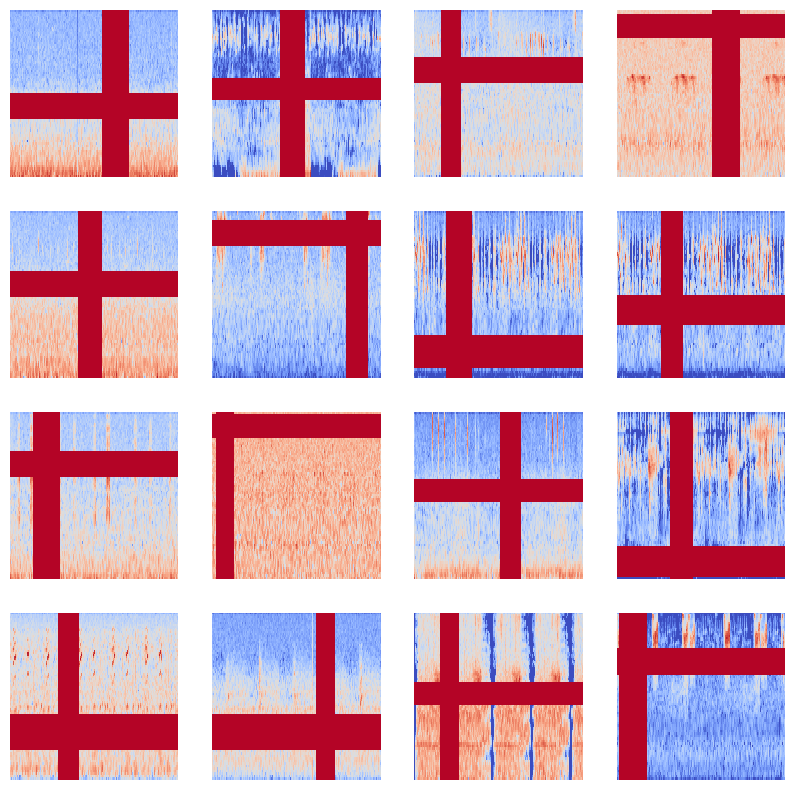

In [10]:
# display a 4x4 grid of augmented spectograms
augmented_outputs = [output for output in train_outputs if output["augmented"]]

plt.figure(figsize=(10, 10))
for i in range(16):
    spectogram_path = os.path.join(train_output_dir, augmented_outputs[i]["spectogram_file"])
    spec = ap.load_log_mel_spectrogram(spectogram_path, type='torch')
    plt.subplot(4, 4, i + 1)
    librosa.display.specshow(
      spec,
      sr=SAMPLE_RATE,
      hop_length=log_mel_params["hop_length"],
      x_axis="frames",
      y_axis="mel",
  )
    plt.axis("off")

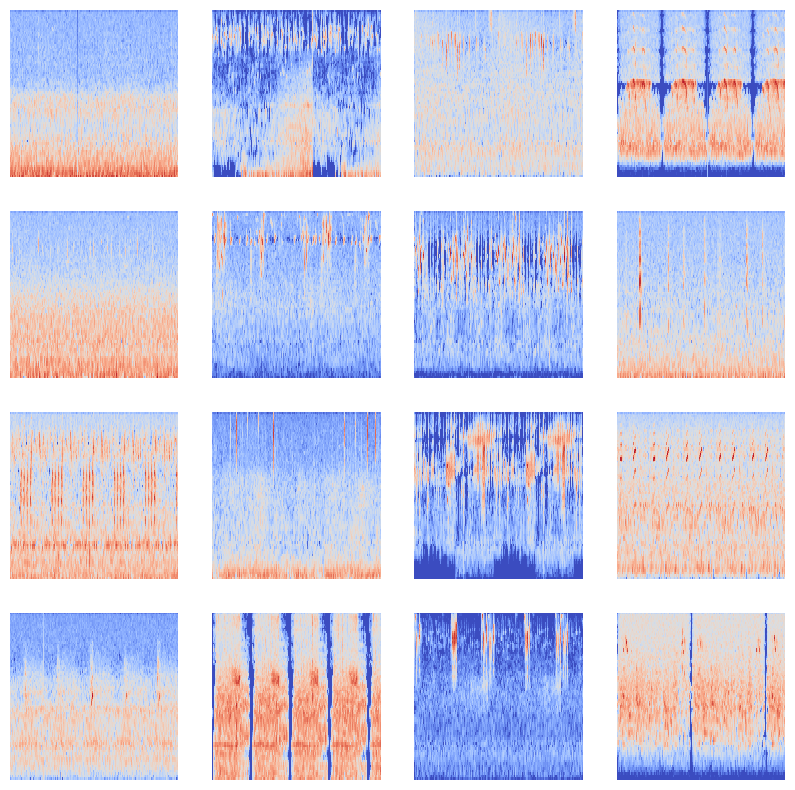

In [11]:
# display a 4x4 grid of non-augmented spectograms
non_augmented_outputs = [output for output in train_outputs if not output["augmented"]]

plt.figure(figsize=(10, 10))
for i in range(16):
    spectogram_path = os.path.join(train_output_dir, non_augmented_outputs[i]["spectogram_file"])
    spec = ap.load_log_mel_spectrogram(spectogram_path, type='torch')
    plt.subplot(4, 4, i + 1)
    librosa.display.specshow(
      spec,
      sr=SAMPLE_RATE,
      hop_length=log_mel_params["hop_length"],
      x_axis="frames",
      y_axis="mel",
  )
    plt.axis("off")